In [3]:
file_prefix <- "ch19.1"
reuse_fit <- T
source("preset.R")

input_file <- "data/FruitflyDataReduced.csv"

# prepare data

In [267]:
data <- read_csv(input_file) %>% mutate(
    CompanionNumber = factor(CompanionNumber), 
    cn_id = as.integer(CompanionNumber)
)

Parsed with column specification:
cols(
  Longevity = col_double(),
  CompanionNumber = col_character(),
  Thorax = col_double()
)



In [22]:
data

Longevity,CompanionNumber,Thorax,cn_id
<dbl>,<fct>,<dbl>,<int>
35,Pregnant8,0.64,3
37,Pregnant8,0.68,3
49,Pregnant8,0.68,3
46,Pregnant8,0.72,3
63,Pregnant8,0.72,3
39,Pregnant8,0.76,3
46,Pregnant8,0.76,3
56,Pregnant8,0.76,3
63,Pregnant8,0.76,3


In [6]:
stan_data <- list(
    N = nrow(data), 
    K = n_distinct(data$CompanionNumber), 
    x = as.integer(data$CompanionNumber), 
    y = data$Longevity, 
    S_y = sd(data$Longevity), 
    M_y = mean(data$Longevity), 
    SIGMA_ALPHA_PARAMS = unlist(gammaShRaFromModeSD(sd(data$Longevity) / 2, sd(data$Longevity) * 2))
)

# model fit 

In [7]:
if (reuse_fit) {
    load(save_file_name("fit"))
} else {
    model <- stan_model(file = "ch19.1.stan")
    fit <- sampling(model, data = stan_data, seed = 123, 
                   chains = 4, warmup = 500, iter = 20000, thin = 4)
    save(model, fit, file = save_file_name("fit"))
}

recompiling to avoid crashing R session



In [11]:
fit

Inference for Stan model: ch19.
4 chains, each with iter=20000; warmup=500; thin=4; 
post-warmup draws per chain=4875, total post-warmup draws=19500.

               mean se_mean   sd    2.5%     25%     50%     75%   97.5% n_eff
alpha_0       57.47    0.07 7.54   42.48   53.47   57.44   61.48   72.85 10525
alpha[1]       5.72    0.08 7.84  -10.03    1.37    5.66   10.12   21.31 10905
alpha[2]       6.85    0.08 7.86   -8.48    2.44    6.73   11.13   22.70 10657
alpha[3]       5.50    0.07 7.85  -10.00    1.14    5.39    9.86   21.38 11152
alpha[4]      -0.71    0.07 7.87  -16.68   -5.09   -0.66    3.65   14.83 11040
alpha[5]     -17.60    0.08 7.91  -34.11  -21.95  -17.32  -13.04   -2.42 10995
sigma         14.97    0.01 0.99   13.19   14.27   14.91   15.60   17.07 18157
sigma_alpha   14.91    0.06 7.65    6.31    9.90   12.92   17.72   34.91 14131
beta_0        57.43    0.01 1.34   54.83   56.53   57.42   58.32   60.03 19677
beta[1]        5.77    0.02 2.62    0.60    4.01    5.79   

# analize result

In [134]:
res <- fit_to_tibble(fit)
x_levels <- levels(data$CompanionNumber)
K <- length(x_levels)
coefs <- map_chr(1:K, ~paste0("beta_", .x))

## predictive

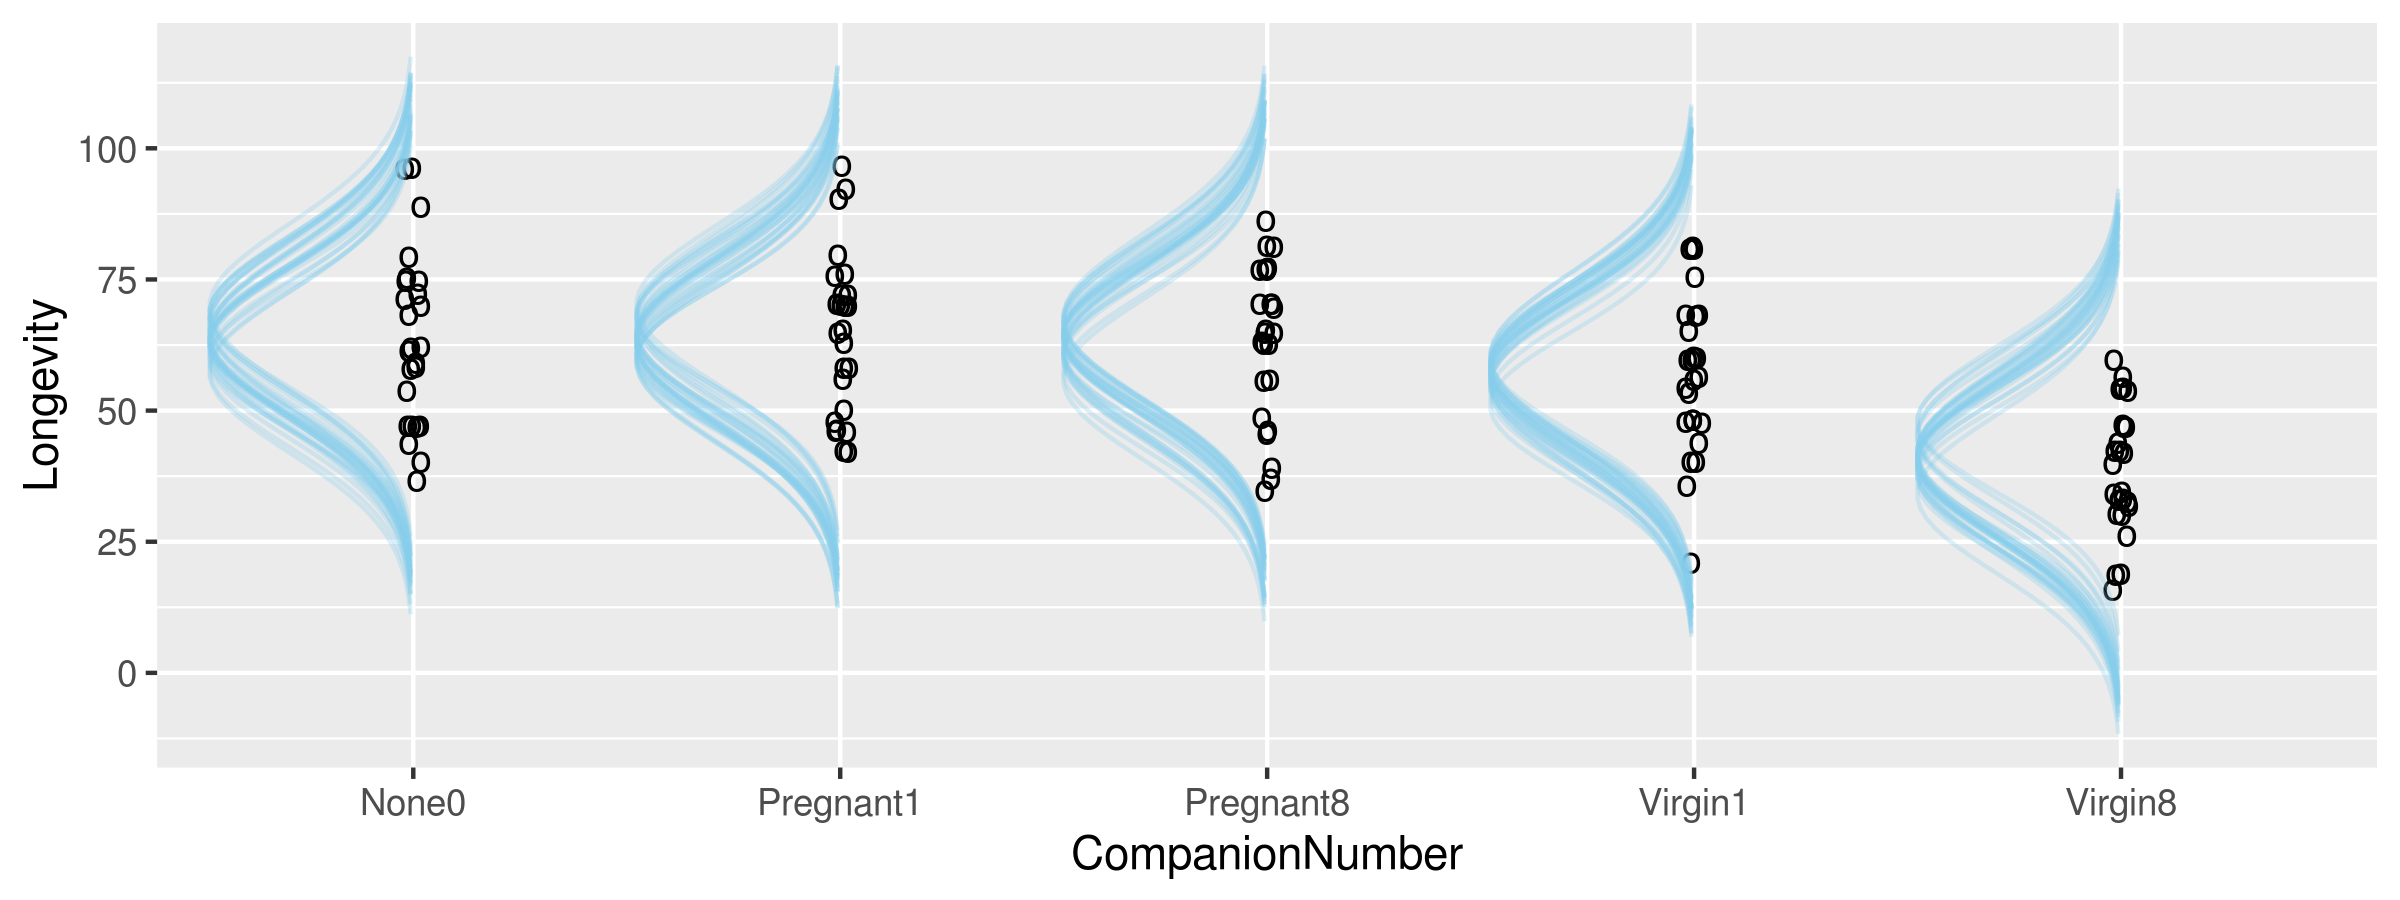

In [190]:
set_plot_size(8, 3)
NUM_SAMPLE_DIST = 30
dist_grid <- res %>% sample_n(NUM_SAMPLE_DIST) %>% select(coefs, "beta_0", "sigma") %>% 
    make_line_grid(xs = seq(1, 5, 1), y_func = beta_0) %>% 
    mutate(Y = ifelse(X == 1, Y + beta_1, Y)) %>% 
    mutate(Y = ifelse(X == 2, Y + beta_2, Y)) %>% 
    mutate(Y = ifelse(X == 3, Y + beta_3, Y)) %>% 
    mutate(Y = ifelse(X == 4, Y + beta_4, Y)) %>% 
    mutate(Y = ifelse(X == 5, Y + beta_5, Y)) %>% 
    make_tdist_grid(point_x = X, point_y = Y, scale = sigma)
ggplot(data) + 
    geom_jitter(aes(CompanionNumber, Longevity), width = 0.02, shape = 'o', size = 3) + 
    geom_path(data = dist_grid, aes(XX, YY, group = point_id), color = "skyblue", alpha = 0.3)

## posteria of all parameters

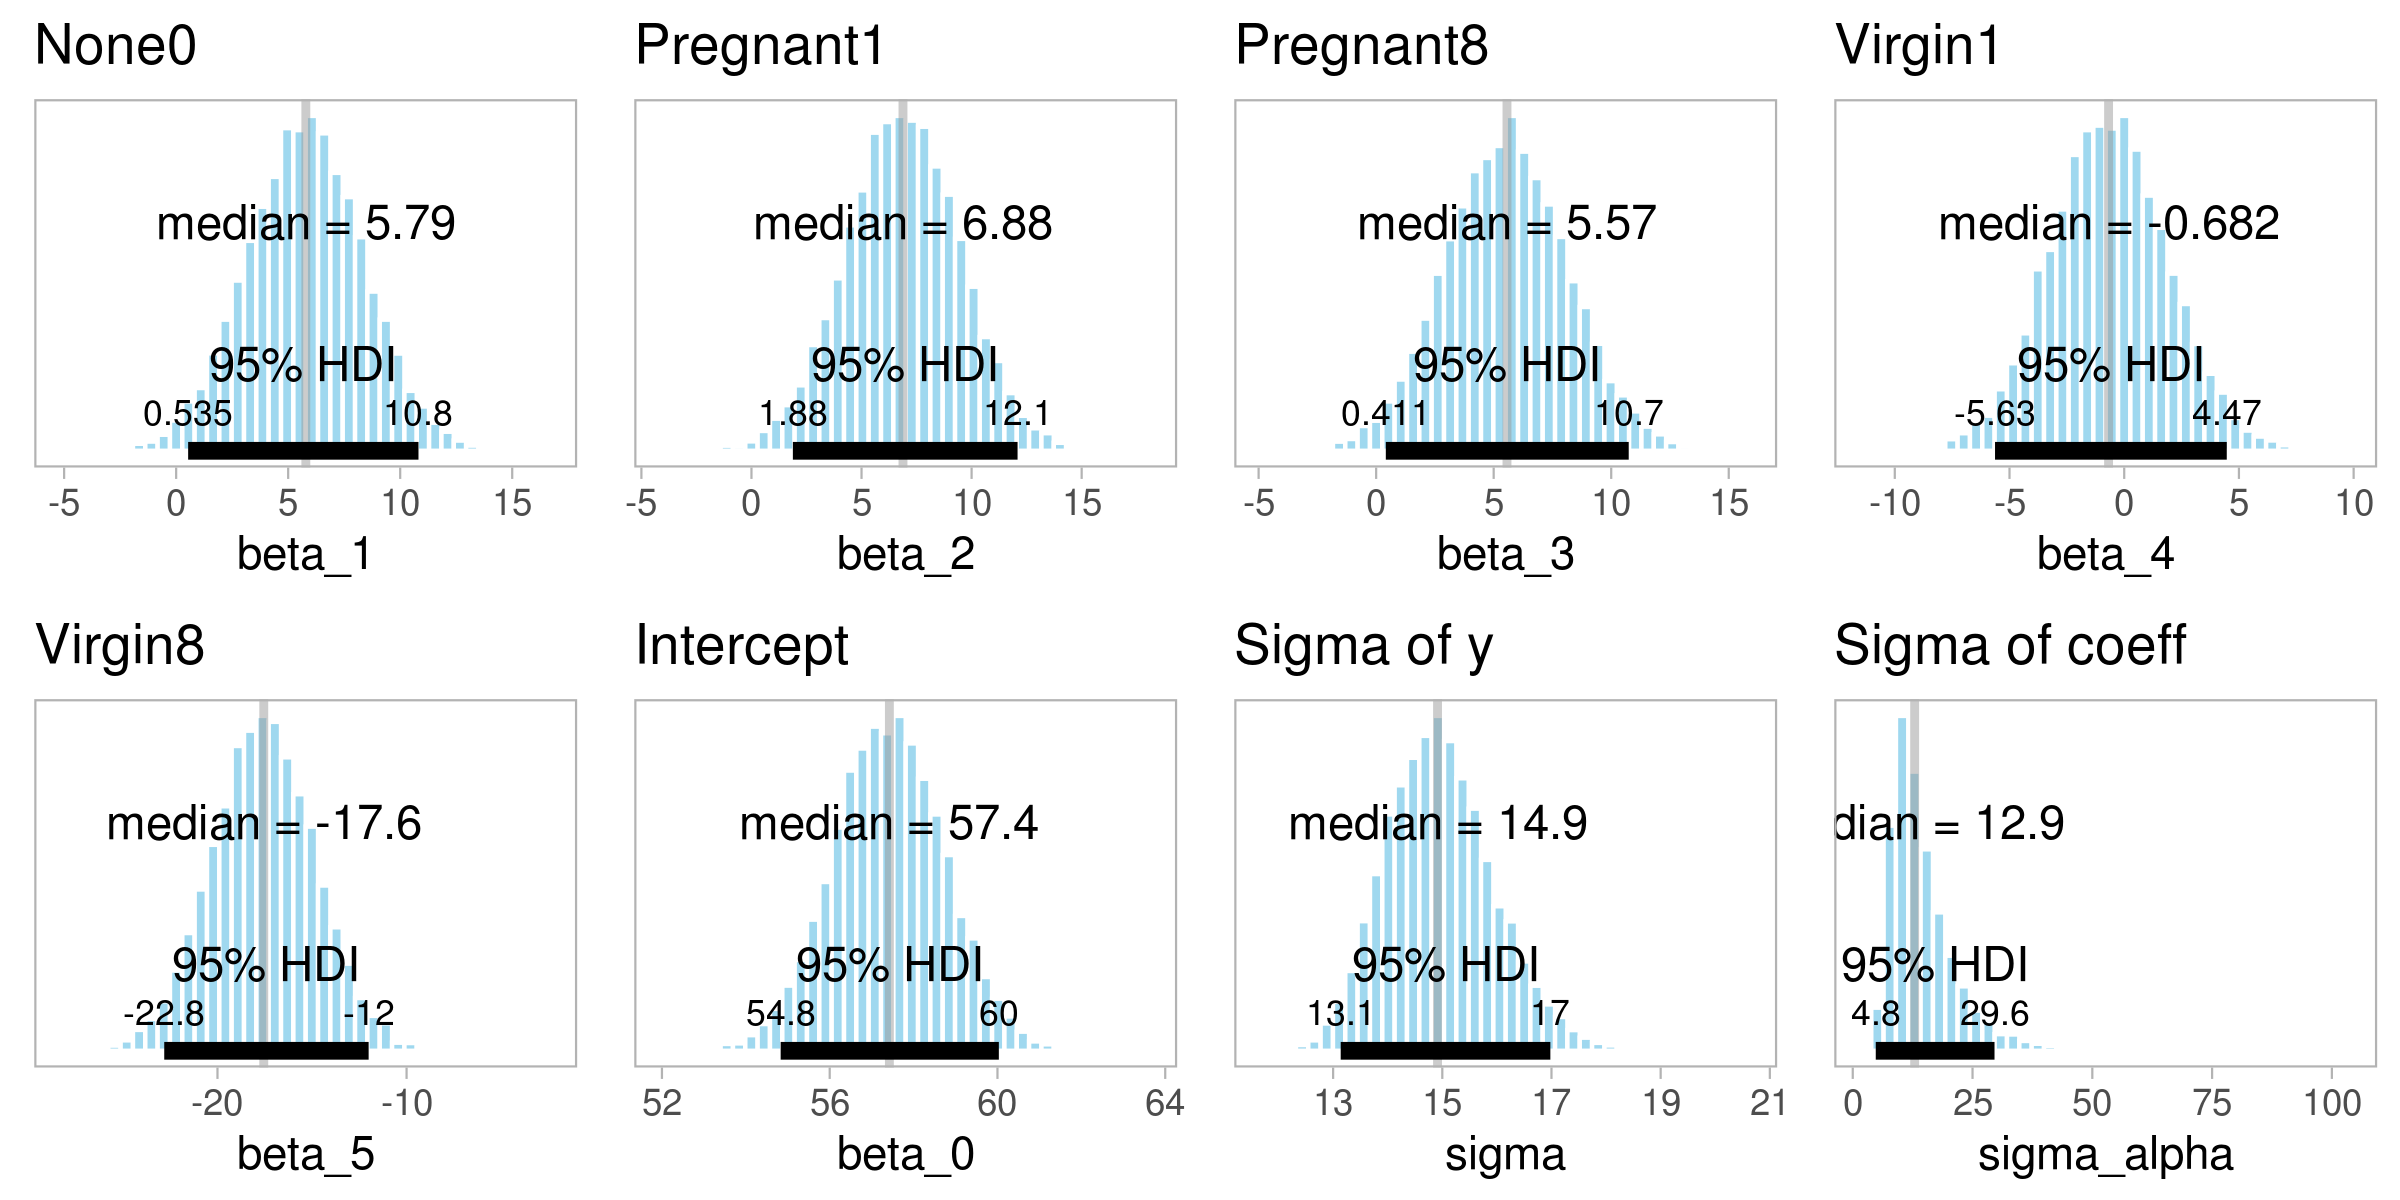

In [35]:
set_plot_size(8, 4)
coeffs <- map_chr(1:5, ~"beta_" %+% .x)
coeff_x_names <- levels(data$CompanionNumber)
params = c(coeffs, "beta_0", "sigma", "sigma_alpha")
titles = c(coeff_x_names, "Intercept", "Sigma of y", "Sigma of coeff")
grid.arrange(
    grobs = map2(params, titles, ~plot_post(res, .x, title = .y)), 
    ncol = 4
)

## pair-wise diff of betas

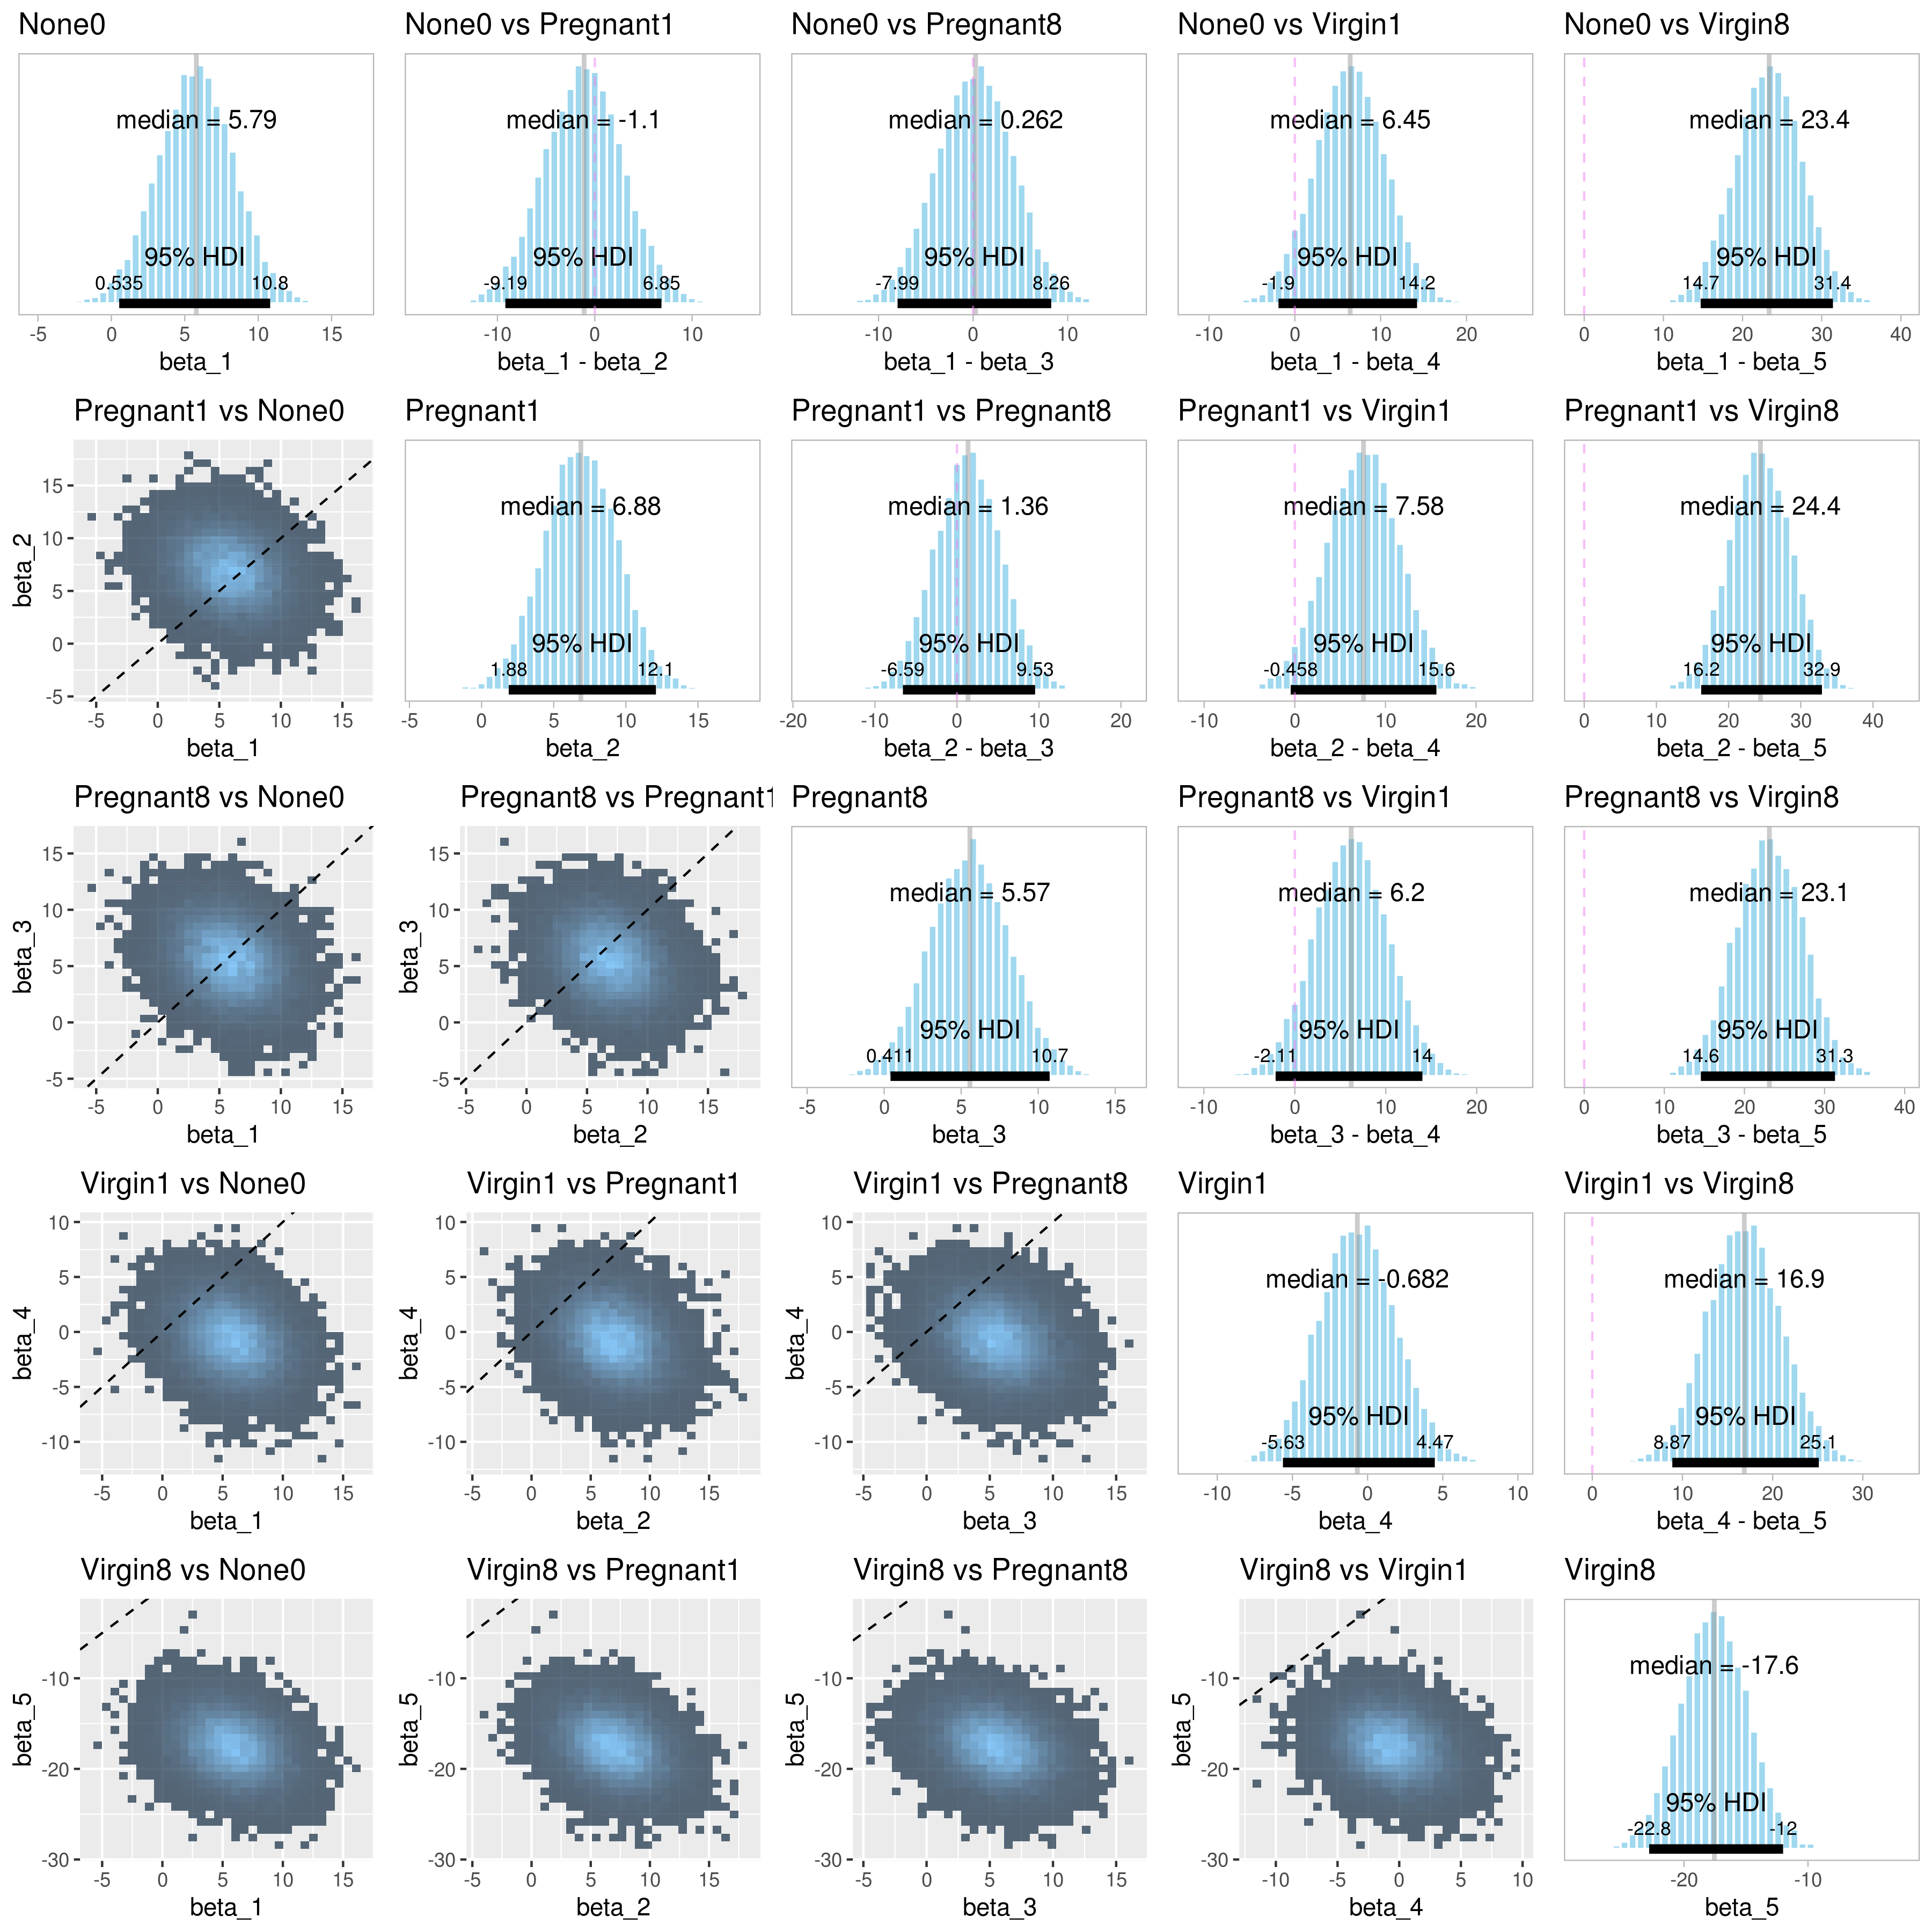

In [189]:
set_plot_size(12, 12)
plot_post_pair_diff(res, 1:5, "beta", t_names = x_levels)

## contrast

In [263]:
make_contrast_title <- function(g1, g2) {
    paste(g1, collapse = ".") %+% " vs " %+% paste(g2, collapse = ".")
}
make_group_diff_data <- function(res, g1, g2) {
    g1_mean <- res %>% select(name_to_coef(g1, x_levels, "beta_")) %>% rowMeans()
    g2_mean <- res %>% select(name_to_coef(g2, x_levels, "beta_")) %>% rowMeans()
    tibble(g1 = g1_mean, g2 = g2_mean)
}
plot_post_by_contrast <- function(res, g1, g2, rope = NULL) {
    make_group_diff_data(res, g1, g2) %>% 
        mutate(diff = g1 - g2) %>% 
        plot_post("diff", rope = rope, title = make_contrast_title(g1, g2))
}
plot_post_by_contrast_effect_size <- function(res, g1, g2, rope = NULL) {
    sigma = res$sigma
    make_group_diff_data(res, g1, g2) %>% 
        mutate(effective_size = (g1 - g2) / sigma) %>% 
        plot_post("effective_size", rope = rope, title = make_contrast_title(g1, g2))
}

In [264]:
contrasts = list( 
  list(g1 = c("Pregnant1", "Pregnant8"), g2 = c("None0")), 
  list(g1 = c("Pregnant1", "Pregnant8", "None0"), g2 = c("Virgin1")), 
  list(g1 = c("Virgin1"), g2 = c("Virgin8")), 
  list(g1 = c("Pregnant1", "Pregnant8", "None0"), g2 = c("Virgin1", "Virgin8"))
)

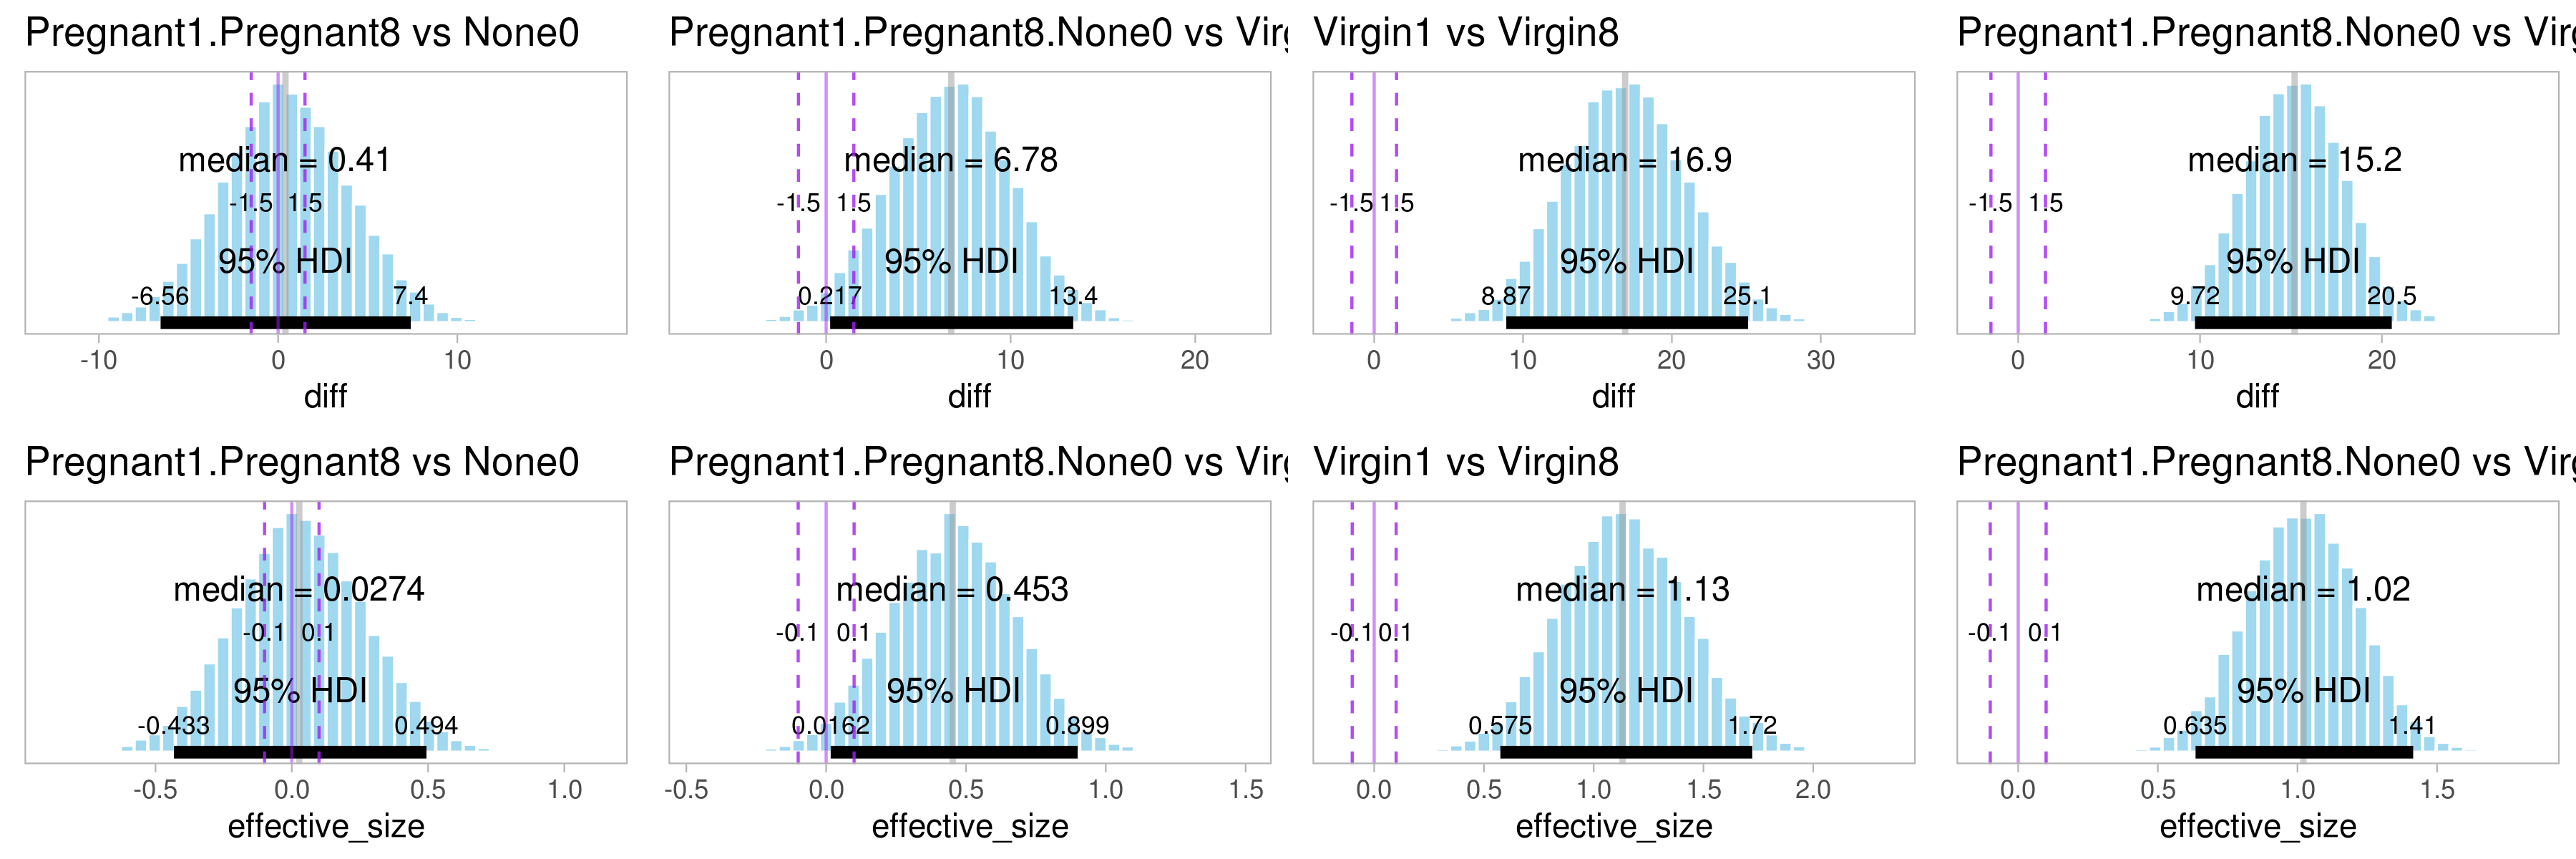

In [265]:
set_plot_size(12, 4)
grid.arrange(
    grobs = c(
        map(contrasts, ~plot_post_by_contrast(res, .x$g1, .x$g2, rope = c(-1.5, 1.5))), 
        map(contrasts, ~plot_post_by_contrast_effect_size(res, .x$g1, .x$g2, rope = c(-0.1, 0.1)))
    ), 
    ncol = 4
)